## Rotation Prediction
In [1], authors propose to predict the geometric transformation applied to the entire image

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

They propose to use rotations by 0, 90, 180, 270 degrees as trasformations.

[1] S. Gidaris et al. “Unsupervised Representation Learning by Predicting Image Rotations”. In: ICLR. 2018.

Let's load all libraries, we will use pytorch and pytorch vision, and check whether we are using CPU or GPU

In [ ]:
import os
import math

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
torch.manual_seed(42) # Setting the seed

## Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import STL10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler

## Plot Options
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
plt.set_cmap("cividis")
%matplotlib inline
sns.set()

# save/load models
import torch
import gdown

# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Ensure that you are using GPU and all CPU workers
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

# For reproducibility
np.random.seed(666)
torch.manual_seed(666)

Device: cuda:0
Number of workers: 2


<Figure size 640x480 with 0 Axes>

As Dataset, we will use the STL-10 dataset (https://cs.stanford.edu/~acoates/stl10/).
It is an image recognition dataset for developing self-supervised and unsupervised feature learning, deep learning algorithms. It is inspired by the CIFAR-10 dataset but with some modifications. In particular, each class has fewer labeled training examples than in CIFAR-10, but a very large set of unlabeled examples is provided.

Overview of the dataset:
- 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
- Images are 96x96 pixels, color.
- 5000 training images (10 pre-defined folds), 8000 test images.
- 100000 unlabeled images. These examples are extracted from a similar but broader distribution of images. For instance, it contains other types of animals (bears, rabbits, etc.) and vehicles (trains, buses, etc.) in addition to the ones in the labeled set.
- Images were acquired from labeled examples on $ImageNet$.

Pytorch proposes two practical data primitives, called DataSet and DataLoader, to handle datasets for pre-processing and training.
There are many data-sets pre-loaded, such as STL-10. For more info: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In particular, we can easily compose several data-augmentations (transformations), that are automatically applied to the images of the dataset. Here we have an exemple with the transformations used in [1].

We will use these transformations in the following.

**Question**: What's the size of the images after the transformations ? We have two different transformations, one for Training and one for Testing. Why in your opinion ?

 **Answer**: RandomResizedCrop randomly crops a square of size 224 from the original image, and the other transformations do not tamper wth the image size. Thus, the size of the train images after transformation would be 224x224. In the case of test images, the image is first resized to 256, and then the center of the image is cropped to get a 224x224 sized image (with the assumption that the main content of the image would be in that central area). Hence, the size of the test images after these transformations will also be 224x224 pixels.


The reason for having different transformations for training and testing is to introduce diversity during training by applying random transformations- random cropping and flipping, which can help the model generalize better to unseen data. However, during testing, we want to evaluate the model's performance on the original, unaltered images. So, we typically use deterministic transformations such as resizing and center cropping for testing.

In [ ]:
transformTrain = transforms.Compose([
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # these are the average and std from ImageNet
         ])

transformTest = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
         ])

We will use only the training and test datasets (few images) to speed up computations.

In [ ]:
train_dataset = STL10(root="./data", split="train", download=True, transform=transformTrain)
test_dataset = STL10(root="./data", split="test", download=True, transform=transformTest)

Files already downloaded and verified
Files already downloaded and verified


Let's have a look at the training and test datasets.

In [ ]:
# Train dataset
classes=train_dataset.classes
print(classes)
print('Number images in Train dataset:' , len(train_dataset)) # retrieve length of dataset
print(train_dataset[3][0].shape) # this is one image
print(train_dataset[3][1]) # this is a label

#Test dataset
print('Number images in Test dataset:' ,len(test_dataset))
print(test_dataset[0][0].shape) # this is one image

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Number images in Train dataset: 5000
torch.Size([3, 224, 224])
6
Number images in Test dataset: 8000
torch.Size([3, 224, 224])


Let's plot few images to see how are they. We need to de-normalize images using the statics of ImageNet (images come from ImageNet)

In [ ]:
def imshowSTL10(dataset,rows=3,columns=3,figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    for i in range(1, rows*columns+1):
      img = dataset[i][0]

      #REMOVE NORMALIZATION
      mean = torch.tensor([0.485, 0.456, 0.406])
      std = torch.tensor([0.229, 0.224, 0.225])
      unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
      # Clip values to range [0,1] -> possible rounding errors during normalization
      img = np.clip(unnormalize(img).numpy(),0,1)

      label = dataset[i][1]
      fig.add_subplot(rows, columns, i)
      plt.title(dataset.classes[label])
      plt.imshow(np.transpose(img, (1, 2, 0)))
      plt.axis("off")
    plt.show()

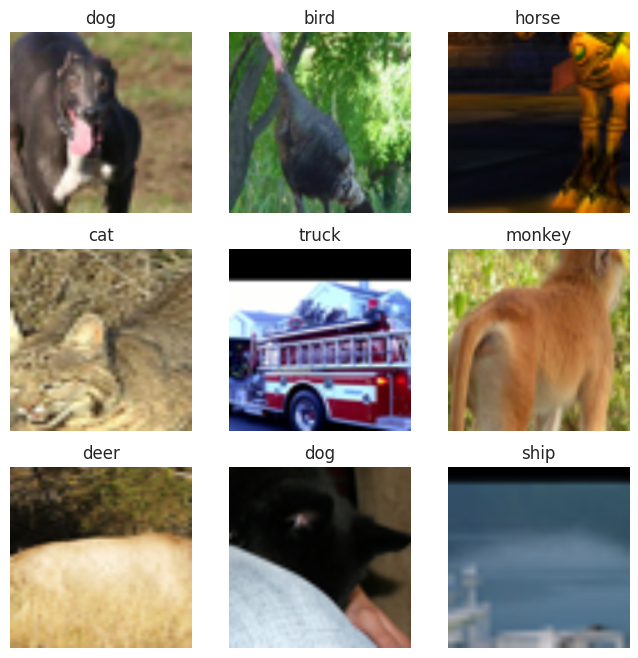

In [ ]:
imshowSTL10(train_dataset)

Now it's time to implement our network.

Since STL10 comes from ImageNet, we take the same network proposed for ImageNet in [1], inspired by AlexNet.

Here you can find the (modified) version of AlexNet (e.g., no DropOut) borrowed from the GitHub of the authors.  

**Question**: Choose an approriate value for num_classes and explain why

 **Answer**: We are training the AlexNet for a pretext case, in this case, rotation prediction. A rotation in this work can be one of 0, 90, 180, 270 degrees, thus haveing class labels 0, 1, 2, 3 respectively. As a result, num_classes = 4. Later, for downstream tasks, the classifier component of the then trained AlexNet will be discarded, and a new classifier take its place which might have a different number of classes depending on the dataset, 10 in the case of STL10.

In [ ]:
# Code borrowed from https://github.com/gidariss/FeatureLearningRotNet
# AlexNet
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        num_classes = 4 ###########

        conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )
        pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
        )
        conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        num_pool5_feats = 6 * 6 * 256
        fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_pool5_feats, 4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
        )
        classifier = nn.Sequential(
            nn.Linear(4096, num_classes),
        )

        self._feature_blocks = nn.ModuleList([
            conv1,
            pool1,
            conv2,
            pool2,
            conv3,
            conv4,
            conv5,
            pool5,
            fc_block,
            classifier,
        ])
        self.all_feat_names = [
            'conv1',
            'pool1',
            'conv2',
            'pool2',
            'conv3',
            'conv4',
            'conv5',
            'pool5',
            'fc_block',
            'classifier',
        ]
        assert(len(self.all_feat_names) == len(self._feature_blocks))

    def _parse_out_keys_arg(self, out_feat_keys):

        # By default return the features of the last layer / module.
        out_feat_keys = [self.all_feat_names[-1],] if out_feat_keys is None else out_feat_keys

        if len(out_feat_keys) == 0:
            raise ValueError('Empty list of output feature keys.')
        for f, key in enumerate(out_feat_keys):
            if key not in self.all_feat_names:
                raise ValueError('Feature with name {0} does not exist. Existing features: {1}.'.format(key, self.all_feat_names))
            elif key in out_feat_keys[:f]:
                raise ValueError('Duplicate output feature key: {0}.'.format(key))

        # Find the highest output feature in `out_feat_keys
        max_out_feat = max([self.all_feat_names.index(key) for key in out_feat_keys])

        return out_feat_keys, max_out_feat

    def forward(self, x, out_feat_keys=None):
        """Forward an image `x` through the network and return the asked output features.
        Args:
          x: input image.
          out_feat_keys: a list/tuple with the feature names of the features
                that the function should return. By default the last feature of
                the network is returned.
        Return:
            out_feats: If multiple output features were asked then `out_feats`
                is a list with the asked output features placed in the same
                order as in `out_feat_keys`. If a single output feature was
                asked then `out_feats` is that output feature (and not a list).
        """
        out_feat_keys, max_out_feat = self._parse_out_keys_arg(out_feat_keys)
        out_feats = [None] * len(out_feat_keys)

        feat = x
        for f in range(max_out_feat+1):
            feat = self._feature_blocks[f](feat)
            key = self.all_feat_names[f]
            if key in out_feat_keys:
                out_feats[out_feat_keys.index(key)] = feat

        out_feats = out_feats[0] if len(out_feats)==1 else out_feats
        return out_feats

    def get_L1filters(self):
        convlayer = self._feature_blocks[0][0]
        batchnorm = self._feature_blocks[0][1]
        filters = convlayer.weight.data
        scalars = (batchnorm.weight.data / torch.sqrt(batchnorm.running_var + 1e-05))
        filters = (filters * scalars.view(-1, 1, 1, 1).expand_as(filters)).cpu().clone()

        return filters

And here it's the most important part of the code.

We build the RotationPrediction Module.

As in [1], we use the 'conv5' layer as representation features and a small classifier, as proposed in the paper.

The key part is in the 'forward' function and in '_preprocess'.

**Question**: complete the code XXXXXX in the '_preprocess' function. Remember that we are implementing the method of [1] as shown in the figure at the beginning of this TP.

In [ ]:
class RotationPrediction(nn.Module):
    metrics = ['Loss', 'Acc1']
    metrics_fmt = [':.4e', ':6.2f']

    def __init__(self, n_classes_classifier, device):
        super().__init__()
        self.device=device
        self.model = AlexNet().to(self.device)
        self.latent_dim = 256 * 13 * 13 # as defined in [1]
        self.feat_layer = 'conv5' # as defined in [1]
        self.n_classes_classifier = n_classes_classifier

    # Same Classifier as defined in [1]
    def construct_classifier(self):
        classifier = nn.Sequential(
            nn.AdaptiveMaxPool2d((6, 6)),
            nn.BatchNorm2d(256, affine=False),
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, self.n_classes_classifier)
        )
        classifier=classifier.to(self.device)
        return classifier

    def forward(self, images):
        images=images.to(self.device)
        batch_size = images.shape[0]

        #images must have a torch.Size([batch_size, Channels, Height, Width])
        #target must have a torch.Size([batch_size])
        images, targets = self._preprocess(images)
        targets = targets.to(self.device)

        logits, zs = self.model(images, out_feat_keys=('classifier', self.feat_layer))
        loss = F.cross_entropy(logits, targets).to(self.device)

        pred = logits.argmax(dim=-1)
        correct = pred.eq(targets).float().sum()
        acc = correct / targets.shape[0] * 100.

        zs = zs[:batch_size]
        return dict(Loss=loss, Acc1=acc), zs[:batch_size]

    def encode(self, images, flatten=True):
        zs = self.model(images, out_feat_keys=(self.feat_layer,))
        if flatten:
          return zs.flatten(start_dim=1)
        return zs

    def _preprocess(self, images):
        batch_size = images.shape[0]
        # Remember that the rotations should be computed using only two operations...
        rotated_90_images = torch.flip(torch.transpose(images, 2, 3), dims=[2])
        rotated_180_images = torch.flip(torch.flip(images, dims=[2]), dims=[3])
        rotated_270_images = torch.transpose(torch.flip(images, dims=[2]), 2, 3)

        # These are the Images to Predict and must have a torch.Size([batch_size, Channels, Height, Width])
        images_batch = torch.cat([images, rotated_90_images, rotated_180_images, rotated_270_images], dim=0)
        # Target are Labels $y$ and must have a torch.Size([batch_size])
        targets = torch.tensor([0, 1, 2, 3]).repeat_interleave(batch_size)
        return images_batch, targets



Here we train our algorithm and evaluate its prediction power on a test set (function 'validate') using the function `accuracy`.

**Question**: Do you understand what the function accuracy compute ? Explain what the output `res` contains

**Answer**: The accuracy function computes the accuracy of the model's predictions by comparing the top-k predicted labels with the target labels for each sample in the batch. It returns a list containing the accuracy percentage for each value of k specified in the topk argument. For example, if topk = (1, 5), res will contain the accuracy for top-1 and top-5 predictions, respectively. This allows for flexible evaluation of the model's performance, particularly in scenarios where considering multiple possible predictions is beneficial, such as in multi-class classification tasks, where the top predictions of the model are desired to be observed.

In [ ]:
def accuracy(output, target, topk=(1,)):

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

Now we can define our train function. As you can see, we separately optimize the model $f$ and the classifier

In [ ]:
def train(train_loader, model, classifier, optimizer, optimizer_classifier, epoch, device):

    model.train()
    classifier.train()
    top1=[]
    top5=[]

    for i, (images, target) in enumerate(train_loader):
        # compute loss
        bs = images.shape[0]
        images = images.to(device)
        target = target.to(device)
        out, zs = model(images)
        zs = zs.detach() # detach from the graph,  requires_grad = False

        # compute optimizer step for ssl task using the previously defined Loss function of the model
        optimizer.zero_grad()
        out['Loss'].backward()
        optimizer.step()

        # compute loss
        logits = classifier(zs)
        loss = F.cross_entropy(logits, target)

        # compute accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1.append(acc1[0])
        top5.append(acc5[0])

        # computeoptimizer step for classifier using the cross entropy loss
        optimizer_classifier.zero_grad()
        loss.backward()
        optimizer_classifier.step()

        #if i % 20 == 0:
        #    print('Epoch {}, Iter: {} out of {}, Average loss: {:.4f}, acc 1: {:.4f}'.format(epoch, i, len(train_loader), loss / len(train_loader.dataset),acc1[0]))

    print('Epoch: {}, Average loss: {:.4f}, Average acc 1: {:.4f}, Average acc 5: {:.4f}'.format(epoch, loss / len(train_loader.dataset),sum(top1)/len(top1), sum(top5)/len(top5)))
    return sum(top1)/len(top1), sum(top5)/len(top5)

Here, we define the:
- DataLoader, a pytorch object that wraps an iterable around the Dataset to enable easy access to the samples duing training or validation
- optimization process
- the sceduler
- all hyper-parameters (max epochs, batch size, lr, weight decay,etc.)

Please note that it will lauch the training process. It can last some time... OR

you can directly load a pre-trained model in the following cell !

**Question**: what's the correct value for n_classes_classifier using the STL dataset ?

**Answer**: n_classes_classifier = 10, because STL10 has 10 classes of images on which we are performing a multi-class classification task.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
maxepochs=50 # maximum number of epochs
bs=128 # batch size
lr_initial=0.01 # initial learning rate
wd=5e-4 # weight decay
n_classes_classifier = 10

# Ensure that you are using GPU and all CPU workers
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

train_loader = data.DataLoader(train_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=True)

model = RotationPrediction(n_classes_classifier = n_classes_classifier, device=device)
classifier = model.construct_classifier()

optimizer = torch.optim.Adam(model.parameters(), lr=lr_initial, weight_decay=wd)
optimizer_classifier = torch.optim.Adam(classifier.parameters(), lr=lr_initial)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=maxepochs)
scheduler_classifier = lr_scheduler.CosineAnnealingLR(optimizer_classifier, T_max=maxepochs)

top1Train=[]
top5Train=[]

for epoch in tqdm(range(maxepochs)):
  top1Tr, top5Tr = train(train_loader, model, classifier, optimizer, optimizer_classifier, epoch, device)
  top1Train.append(top1Tr)
  top5Train.append(top5Tr)
  scheduler.step()
  scheduler_classifier.step()


Device: cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, Average loss: 0.0020, Average acc 1: 16.7383, Average acc 5: 61.9531
Epoch: 1, Average loss: 0.0027, Average acc 1: 18.1836, Average acc 5: 66.2695
Epoch: 2, Average loss: 0.0024, Average acc 1: 19.4336, Average acc 5: 67.1680
Epoch: 3, Average loss: 0.0026, Average acc 1: 20.7812, Average acc 5: 70.7422
Epoch: 4, Average loss: 0.0017, Average acc 1: 21.5430, Average acc 5: 72.3633
Epoch: 5, Average loss: 0.0009, Average acc 1: 23.9258, Average acc 5: 75.1367
Epoch: 6, Average loss: 0.0028, Average acc 1: 22.1289, Average acc 5: 73.1445
Epoch: 7, Average loss: 0.0013, Average acc 1: 21.5039, Average acc 5: 75.6445
Epoch: 8, Average loss: 0.0012, Average acc 1: 22.3828, Average acc 5: 73.5742
Epoch: 9, Average loss: 0.0004, Average acc 1: 22.7148, Average acc 5: 74.3750
Epoch: 10, Average loss: 0.0016, Average acc 1: 22.7930, Average acc 5: 74.7070
Epoch: 11, Average loss: 0.0006, Average acc 1: 22.5781, Average acc 5: 74.7656
Epoch: 12, Average loss: 0.0010, Average acc 1: 22

If you want to save your model, we can use torch.save

In [ ]:
os.makedirs('models/', exist_ok=True)
filename = 'models/checkpoint_rotation_50epochs.pth.tar'
torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'state_dict_classifier': classifier.state_dict(),
                'optimizer_classifier': optimizer_classifier.state_dict(),
                'schedular_classifier': scheduler_classifier.state_dict()
            }, filename)

If you want, here you can download the same model as before but already pre-trained for 50 epochs.

It's important to set the 'model.eval()' since we want to evaluate it and not train it (no gradient is computed and parameters are not updated)


In [ ]:
os.makedirs('models/', exist_ok=True)
# Download the Test set
file_url = 'https://drive.google.com/uc?id=1ADslBKLjo1ulEfmz12ufEk2cjqnYJVRp'
ckpt_pth = 'models/checkpoint_rotation_50epochs.pth.tar'
gdown.download(file_url, ckpt_pth, quiet=True)
n_classes_classifier = 10

# Load checkpoint file of already trained model
ckpt = torch.load(ckpt_pth)

# Load Model parameters and set it into eval mode
model_download = RotationPrediction(n_classes_classifier=n_classes_classifier, device=device)
model_download.load_state_dict(ckpt['state_dict'])
model_download.to(device)
model_download.eval()

# Load classifier model
classifier_download = model_download.construct_classifier()
classifier_download.load_state_dict(ckpt['state_dict_classifier'])
classifier_download.to(device)
classifier_download.eval()


Sequential(
  (0): AdaptiveMaxPool2d(output_size=(6, 6))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=9216, out_features=10, bias=True)
)

Now we can test our model on the test set.

**Question**: complete the code to compute average loss, average acc 1 and average acc 5 on the test set

In [ ]:
def test(test_loader, model, classifier, device):
    model.eval()
    classifier.eval()
    top1=[]
    top5=[]
    with torch.no_grad():
      for i, (images, target) in tqdm(enumerate(test_loader)):
        bs = images.shape[0]
        images = images.to(device)
        target = target.to(device)

        zs = model.encode(images, flatten = False)
        logits = classifier(zs)
        loss = F.cross_entropy(logits, target)

        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1.append(acc1[0])
        top5.append(acc5[0])

    average_loss = loss / len(train_loader.dataset)
    average_acc1 = sum(top1)/len(top1)
    average_acc5 = sum(top5)/len(top5)

    return average_loss, average_acc1, average_acc5

In [ ]:
bs=128 # batch size

test_loader = data.DataLoader(test_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)

# Choose either the model trained here or the downloaded model
model_test=model
# model_test=model_download

classifier_test=classifier
# classifier_test=classifier_download

average_loss, average_acc1, average_acc5  = test(test_loader, model_test, classifier_test, device)
print('Average loss: {:.4f}, Average acc 1: {:.4f}, Average acc 5: {:.4f}'.format(average_loss, average_acc1, average_acc5))

0it [00:00, ?it/s]

Average loss: 0.0002, Average acc 1: 50.3596, Average acc 5: 94.7173


In [ ]:
# Choose either the model trained here or the downloaded model
# model_test=model
model_test=model_download

# classifier_test=classifier
classifier_test=classifier_download

average_loss, average_acc1, average_acc5  = test(test_loader, model_test, classifier_test, device)
print('Average loss: {:.4f}, Average acc 1: {:.4f}, Average acc 5: {:.4f}'.format(average_loss, average_acc1, average_acc5))

0it [00:00, ?it/s]

Average loss: 0.0002, Average acc 1: 47.6687, Average acc 5: 93.1300


**Question**: are you satisfied with the obtained result ? If you had more time, what would you do to improve the results ?

I managed to get a satisfactory top-5 accuracy (similar to the downloaded model). The top-1 accuracy is not that great, but then again, neural networks being data hungry, 500 images per class (assuming the dataset of 5000 images used here is uniformly distributed amongst the 10 classes) is not a lot.

To improve the results I could consider several strategies. An effective one would be experimenting with different pretext tasks, eg. given a grayscale version of an image, predicting its color; predicting the missing pixels within a randomly-masked patch; training an autoencoder to generate the input data from its latent representation (and using that for the downstream task), or even using a combination of different pretext tasks. Instead of using AlexNet, some more modern and powerful architectures like ResNet, EfficientNet, or DenseNet etc. could be tried. A very basic but highly effective strategy from the view of training the model would be using learning rate schedulers.